In [1]:
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from imgaug import augmenters as iaa
import imgaug as ia


/home/marci/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/marci/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marci/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / 

In [5]:
import os
import numpy as np
from nilearn import image
from imgaug import augmenters as iaa
import imgaug as ia


class MRIHandler():

    INPUT_SHAPE = (320, 320, 80)
    LAST_CHANNEL_NO = INPUT_SHAPE[2]
    ROTATION_PARAMS = np.array([0, 45, 90, 135, 180, 225, 270])

    IMG_PATH = "imagesTr/"
    LABEL_PATH = "labelsTr/"

    def __init__(self):

        self.paths_to_all_imgs = self._create_path_list(self.IMG_PATH)
        self.paths_to_all_labels = self._create_path_list(self.LABEL_PATH)
        self.batch_size = 2
        self.classes = 2

    def next_batch(self, batch_size=2):
        self.batch_size = batch_size
        ind = np.random.choice(self.paths_to_all_imgs, batch_size)
        imgs, labels = self._load_batch(ind)

        aug_img, aug_labels = self.augment(imgs, labels)

        label_mask = self._create_one_hot_label(aug_labels)

        return aug_img, label_mask, aug_labels

    def augment(self, imgs, labels):
        index = np.random.randint(0, 4, size=self.batch_size)
        actual_rotation = self.ROTATION_PARAMS[index]

        imgs = np.squeeze(imgs, -1)
        aug_imgs = []
        aug_labels = []

        for i in range(len(actual_rotation)):
            rotate = iaa.Affine(rotate=(actual_rotation[i]))

            aug_imgs.append(rotate.augment_image(imgs[i]))
            aug_labels.append(rotate.augment_image(labels[i]))

        return np.expand_dims(aug_imgs, -1), np.array(aug_labels)

    def _load_batch(self, ind):
        imgs = []
        labels = []
        for i in ind:
            s = i.split("/")
            img = image.smooth_img(i, None).get_data()[:, :, :self.LAST_CHANNEL_NO]
            imgs.append(img)

            label_path_name = f'labelsTr/{s[1]}'
            label = image.smooth_img(label_path_name, None).get_data()[:, :, :self.LAST_CHANNEL_NO]
            labels.append(label)
        return np.expand_dims(np.array(imgs), -1), np.array(labels)

    def _create_one_hot_label(self, label_mask):
        mask = np.zeros((self.batch_size, self.INPUT_SHAPE[0], self.INPUT_SHAPE[1], self.INPUT_SHAPE[2],
                         self.classes))

        for c in range(self.batch_size):
            actual_label_mask = label_mask[c]
            for i in range(self.classes):
                equal = np.equal(actual_label_mask, i)
                mask[c, :, :, :, i] = equal

        return mask

    def _create_path_list(self, path):
        return_list = []
        for i in os.listdir(path):
            temp_path = os.path.join(path, i)
            return_list.append(temp_path)
        return return_list

    def load_val_data(self, val_path):
        imgs = []
        labels = []
        val_path_imgs = os.path.join(val_path, "imgs")
        val_path_labels = os.path.join(val_path, "labels")

        for i in os.listdir(val_path_imgs):
            img_path = os.path.join(val_path_imgs, i)
            img = image.smooth_img(img_path, None).get_data()[:, :, :self.LAST_CHANNEL_NO]
            imgs.append(img)

            label_path = os.path.join(val_path_labels, i)
            label = image.smooth_img(label_path, None).get_data()[:, :, :self.LAST_CHANNEL_NO]
            labels.append(label)
        return np.expand_dims(np.array(imgs), -1), np.array(labels)




In [6]:
%matplotlib notebook
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))
        plt.ion()
        f.show()
        f.canvas.draw()

        for i in range(80):
            ax[0].clear()
            ax[1].clear()
            ax[0].imshow(image[0,:,:,i,0])
            ax[1].imshow(mask[0,:,:,i])
            f.canvas.draw()
            
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))
        plt.ion()
        f.show()
        f.canvas.draw()
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        for i in range(80):
            ax[0,0].clear()
            ax[0,1].clear()
            ax[1,0].clear()
            ax[1,1].clear()


            ax[0, 0].imshow(original_image[0,:,:,i,0])

            ax[1, 0].imshow(original_mask[0,:,:,i])

            ax[0, 1].imshow(image[0, :,:,i, 0])

            ax[1, 1].imshow(mask[0,:,:,i])
            
            f.canvas.draw()

In [9]:
dh = MRIHandler()
img, label, orig = dh.next_batch(2)

<IPython.core.display.Javascript object>


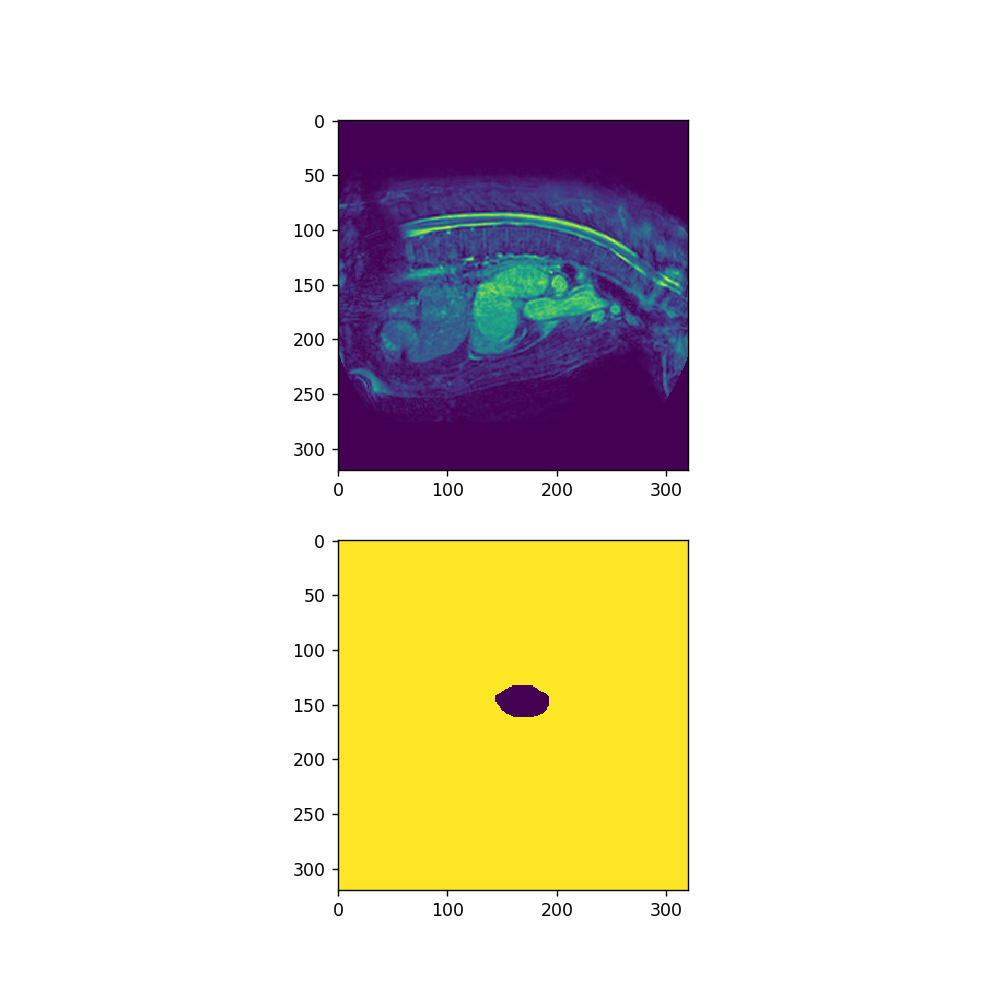

In [10]:
visualize(img, label[:,:,:,:,0])

In [ ]:
class SegNetBasic:
    INPUT_SHAPE = [320, 320, 80]

    def __init__(self, no_classes):
        self.classes = no_classes

    def predict(self, data, is_training):

        d1 = self._decoder_block(data, 16, is_training)
        print(d1)
        d2 = self._decoder_block(d1, 16, is_training)
        print(d2)
        d3 = self._decoder_block(d2, 32, is_training)
        print(d3)
        d4 = self._decoder_block(d3, 32, is_training)
        print(d4)

        e1 = self._encoder_block(d4, 32, is_training)
        e2 = self._encoder_block(e1, 16, is_training)
        e3 = self._encoder_block(e2, 16, is_training)
        e4 = self._encoder_block(e3, self.classes, is_training)

        return e4

    def loss(self, image, mask):
        class_weight = tf.constant([0.01, 1])
        logits = tf.multiply(image, class_weight)
        print(logits)
        recon_error = tf.nn.softmax_cross_entropy_with_logits(labels=mask, logits=image)
        print(recon_error)

        cost = tf.reduce_mean(recon_error)
        return cost

    def optimizer(self, lr=1e-5):
        return tf.train.AdamOptimizer(learning_rate=lr)

    def _decoder_block(self, data, no_filters, is_training):
        l1 = tf.layers.conv3d(data, no_filters, [3, 3, 3], padding="same")
        m1 =  tf.layers.max_pooling3d(l1, [2,2,2], [2,2,2], padding="same")
        o1 = tf.nn.relu(m1)
        return o1

    def _encoder_block(self, data, no_filters, is_training):
        u1 = tf.layers.conv3d_transpose(data, no_filters, kernel_size=[7,7,7], strides=[2,2,2], padding="same")

        return u1

    

def create_prediction_and_label(prediction):
    values = np.argmax(prediction, axis=4)
    values = np.expand_dims(values, 4)
    return values


def pixel_accuracy(prediction, mask, no_classes=2):
    prediction = np.squeeze(prediction, axis=4)
    sum = 0
    target_sum = np.size(mask)

    for i in range(no_classes):
        target = (mask == i)
        pred = (prediction == i)
        correct_pixels = np.logical_and(target, pred)

        if not np.sum(target) == 0:
            sum += np.sum(correct_pixels) / target_sum

    return sum


In [ ]:
tf.reset_default_graph()
import sys
sys.path.append("../")  # noqa
import tensorflow as tf

INPUT_SHAPE = [320, 320, 80]
MAX_CLASS = 2

logdir = "logs/training"
file_writer = tf.summary.FileWriter(logdir, flush_secs=5)
loss_feed = tf.placeholder(tf.float32)
pixel_acc_feed = tf.placeholder(tf.float32)
tensorboard_images = tf.placeholder(tf.float32, [None, INPUT_SHAPE[0], INPUT_SHAPE[1],INPUT_SHAPE[2], 1], name="Tensorboard_Images")
tensorboard_images_labels = tf.placeholder(tf.float32, [None, INPUT_SHAPE[0], INPUT_SHAPE[1],INPUT_SHAPE[2], 1], name="Tensorboard_Images_Labels")
tensorboard_inputs = tf.placeholder(tf.float32, [None, INPUT_SHAPE[0], INPUT_SHAPE[1],INPUT_SHAPE[2], 3], name="Inputs")
loss_summary = tf.summary.scalar("Loss", loss_feed)
pixel_acc_summary = tf.summary.scalar("Pixel_Acc", pixel_acc_feed)
img_summary = tf.summary.image("Predictions", tensorboard_images)
img_summary2 = tf.summary.image("Images", tensorboard_inputs)
img_summary3 = tf.summary.image("Labels", tensorboard_images_labels)


input_im = tf.placeholder(dtype=tf.float32, shape=[None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2], 1], name="input")
mask = tf.placeholder(dtype=tf.float32, shape=[None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2], MAX_CLASS], name="Segmentation")


segnet = SegNetBasic(2)
prediction = segnet.predict(input_im, is_training=True)
cost = segnet.loss(prediction, mask)
optimizer = segnet.optimizer(1e-5)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(cost)


saver = tf.train.Saver(max_to_keep=30)


dh = MRIHandler()
STEP = 3000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, f'checkpoints/model-{STEP}')
    for i in range(STEP, 6000):

        img_batch, label_batch, orig_labels = dh.next_batch(1)
        _, loss, pred = sess.run([train_op, cost, prediction], feed_dict={input_im: img_batch, mask: label_batch})
        print(loss)

        predicted_segmentation = create_prediction_and_label(pred)
        pixel_acc = pixel_accuracy(predicted_segmentation, orig_labels, MAX_CLASS)
        print(pixel_acc)

        if i % 10 != 0:
            summaries = [loss_summary, pixel_acc_summary]
            summary_op = tf.summary.merge(summaries)
            summary = sess.run(summary_op, feed_dict={loss_feed: loss,
                                                      pixel_acc_feed: pixel_acc})

            file_writer.add_summary(summary, i)

        if i % 10 == 0:
            
            img, label = dh.load_val_data("val/")
            pred = sess.run(prediction, feed_dict={input_im: np.expand_dims(img[0],0)})
            pred = create_prediction_and_label(pred)
            pred_sum = np.sum(pred)
            print(f'Ones in Pred:{pred_sum}')
            
            pixel_acc = pixel_accuracy(pred, label, MAX_CLASS)
            print(f'Val Pixel Acc:{pixel_acc}')


        if i % 100 == 0 and i > 0:
            saver.save(sess, "checkpoints/model", global_step=i)



In [ ]:
tf.reset_default_graph()
STEP = 3800
IMG_NO = 0
INPUT_SHAPE = [320, 320, 80]
input_im = tf.placeholder(dtype=tf.float32, shape=[None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2], 1], name="input")

segnet = SegNetBasic(2)
prediction = segnet.predict(input_im, False)
saver = tf.train.Saver()
dh = MRIHandler()

with tf.Session() as sess:
    tf.global_variables_initializer()
    saver.restore(sess, f'checkpoints/model-{STEP}')
    img, label = dh.load_val_data("val/")
    #img, _, label = dh.next_batch(1)
    pred = sess.run(prediction, feed_dict={input_im: np.expand_dims(img[IMG_NO],0)})
    pred = create_prediction_and_label(pred)

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
test_pred = pred*10
pred2 = np.ma.masked_where(test_pred == 0, test_pred)
orig = np.ma.masked_where(label == 0, label)

for i in range(80):
    ax.clear()
    ax.imshow(img[0,:,:,i,0])
    
    ax.imshow(pred2[0,:,:,i,0], alpha=1, cmap="Reds")
    ax.imshow(orig[IMG_NO,:,:,i], alpha=0.5)
    fig.canvas.draw()

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(80):
    ax.clear()
    ax.imshow(img[1,:,:,i,0])
    orig = np.ma.masked_where(label == 0, label)
    ax.imshow(orig[0,:,:,i], alpha=0.7, cmap="Reds")
    fig.canvas.draw()

In [ ]:
def pixel_accuracy(prediction, mask, no_classes=2):
    prediction = np.squeeze(prediction, axis=4)
    sum = 0
    target_sum = np.sum((mask > 0))

    for i in range(1, no_classes):
        target = (mask == i)
        pred = (prediction == i)
        correct_pixels = np.logical_and(target, pred)

        if not np.sum(target) == 0:
            sum += np.sum(correct_pixels) / target_sum

    return sum



In [ ]:
pred = np.array([[0, 1, 1], 
                [1, 1, 1]])
pred = pred.reshape(1, 2, 3, 1, 1)
mask = np.array([[1, 1, 1], 
                [1, 1, 1]])
mask = mask.reshape(1, 2, 3, 1)

In [ ]:
pixel_accuracy(pred, mask)

In [ ]:
np.squeeze(pred, axis=4)

In [ ]:
mask

In [ ]:
from imgaug import augmenters as iaa
import imgaug as ia
from imgaug.augmenters import HorizontalFlip


In [ ]:
dh = MRIHandler()

In [ ]:
dh = MRIHandler()
img, label, orig = dh.next_batch(2)

In [ ]:
label.shape

In [ ]:
%matplotlib notebook
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image[0,:,:,50,0])
        ax[1].imshow(mask[0,:,:,50])
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))
        plt.ion()
        f.show()
        f.canvas.draw()
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        for i in range(80):
            ax[0,0].clear()
            ax[0,1].clear()
            ax[1,0].clear()
            ax[1,1].clear()


            ax[0, 0].imshow(original_image[0,:,:,i,0])

            ax[1, 0].imshow(original_mask[0,:,:,i])

            ax[0, 1].imshow(image[0, :,:,i, 0])

            ax[1, 1].imshow(mask[0,:,:,i])
            
            f.canvas.draw()

In [ ]:
rotation_params = np.array([0, 90, 180, 270])
index = np.random.randint(0, 4, size = 2)
actual_rotation = rotation_params[index]

print(actual_rotation)

In [ ]:
def augment(imgs, labels, rotation_params):
        imgs = np.squeeze(imgs, -1)
        aug_imgs = []
        aug_labels = []
        for i in range(len(rotation_params)):
            rotate = iaa.Affine(rotate=(rotation_params[i]))
            
            aug_imgs.append(rotate.augment_image(imgs[i]))
            aug_labels.append(rotate.augment_image(labels[i]))
        
        return np.expand_dims(aug_imgs, -1), np.array(aug_labels)


In [ ]:
aug_imgs, aug_labels = augment(img, orig, actual_rotation)

In [ ]:
orig.shape

In [ ]:
visualize(aug_imgs, aug_labels, original_image=img, original_mask=orig)


In [ ]:
aug = HorizontalFlip(p=1)

augmented = aug(image=img, mask=label)

image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']

visualize(image_h_flipped, mask_h_flipped, original_image=img, original_mask=label)


In [ ]:
iaa.ElasticTransformation()